In [3]:
import os
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/bmoretz/notebooks/master/MSDS422/Assignment_02/"
DATA_PATH = os.path.join("datasets/bank.csv")
FILE_URL = DOWNLOAD_ROOT + str(DATA_PATH)

# Where to save the figures
PROJECT_ROOT_DIR = "."

RANDOM_SEED = 1

def fetch_bank_data( file_url = FILE_URL, data_path = DATA_PATH):
    if not os.path.isdir( data_path ):
        os.makedirs( data_path )
    urllib.request.urlretrieve(file_url, DATA_PATH)
    
def load_bank_data( file_path = DATA_PATH, sep = ","):
    return pd.read_csv(file_path, sep = sep)

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [4]:
# download data into workspace
if not os.path.isfile(DATA_PATH):
    fetch_bank_data()

# Load the CSV into a DataFrame
bank = load_bank_data(sep = ';')

In [5]:
bank.shape

(4521, 17)

In [6]:
bank.dropna()
bank.shape

(4521, 17)

In [7]:
list(bank.columns.values)

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'response']

In [8]:
# examine the raw data
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [9]:
# mapping function to convert text no/yes to integer 0/1
convert_to_binary = {'no' : 0, 'yes' : 1}

In [10]:
# Convert yes/no string to binary
default = bank['default'].map(convert_to_binary)
housing = bank['housing'].map(convert_to_binary)
loan = bank['loan'].map(convert_to_binary)
response = bank['response'].map(convert_to_binary)

In [11]:
model_data = np.array( [np.array(default), np.array(housing), np.array(loan), np.array(response)]).T

In [12]:
model_data.shape

(4521, 4)

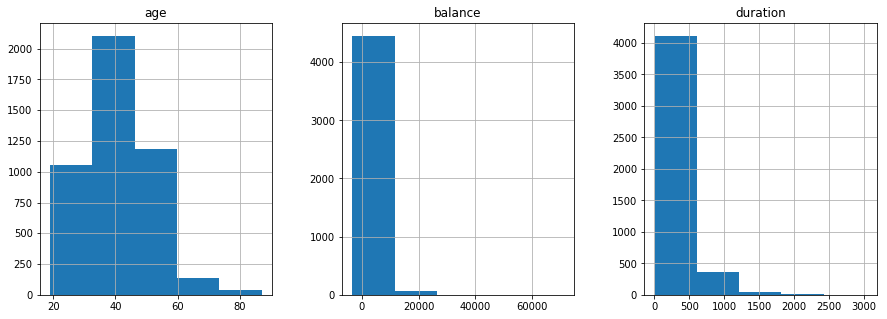

In [13]:
distributions = bank[['age', 'balance', 'duration']].hist( bins = 5, figsize=(15, 5), layout=(1,3))

In [14]:
# Use age distribution to cut into bins
bank['age_group'] = pd.cut(bank.age, bins=[g for g in range(20, 90, 5)], include_lowest=True)
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response,age_group
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no,"(25.0, 30.0]"
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no,"(30.0, 35.0]"
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no,"(30.0, 35.0]"
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no,"(25.0, 30.0]"
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no,"(55.0, 60.0]"


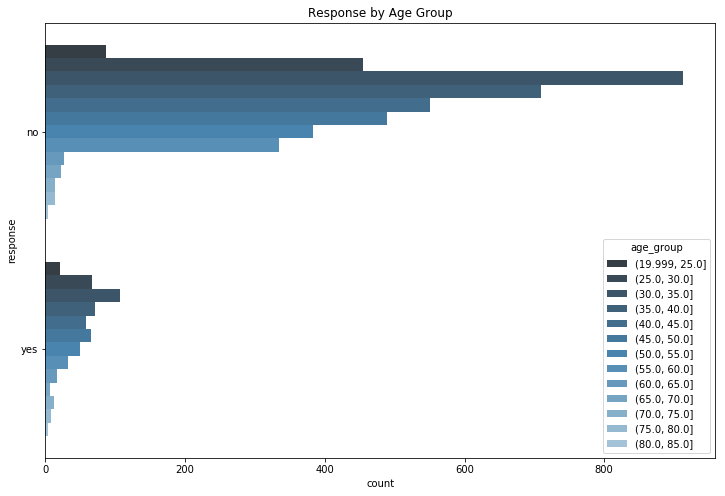

In [15]:
fig=plt.figure()
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(y='response', hue='age_group', data=bank, palette="Blues_d")
plt.title('Response by Age Group')
plt.show()

In [16]:
# cross-validation scoring code adapted from Scikit Learn documentation
from sklearn.metrics import roc_auc_score

In [31]:
# specify the set of classifiers being evaluated
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
names = ["Naive_Bayes", "Logistic_Regression"]

classifiers = [BernoulliNB(alpha=1.0, binarize=0.5, 
                           class_prior = [0.5, 0.5], fit_prior=False), 
               LogisticRegression(solver = 'lbfgs')]

# dimensions of the additive model X input and y response
print('\nData dimensions:', model_data.shape)


Data dimensions: (4521, 4)


In [32]:
# --------------------------------------------------------
# specify the k-fold cross-validation design
from sklearn.model_selection import KFold

In [33]:
# ten-fold cross-validation employed here
N_FOLDS = 10

# set up numpy array for storing results
cv_results = np.zeros((N_FOLDS, len(names)))

In [34]:
kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)

# check the splitting process by looking at fold observation counts
index_for_fold = 0  # fold count initialized 
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold,
          '------------------------------------------')
#   note that 0:model_data.shape[1]-1 slices for explanatory variables
#   and model_data.shape[1]-1 is the index for the response variable    
    X_train = model_data[train_index, 0:model_data.shape[1]-1]
    X_test = model_data[test_index, 0:model_data.shape[1]-1]
    y_train = model_data[train_index, model_data.shape[1]-1]
    y_test = model_data[test_index, model_data.shape[1]-1]   

    print('\nShape of input data for this fold:',
          '\nData Set: (Observations, Variables)')
    print('X_train:', X_train.shape)
    print('X_test:',X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:',y_test.shape)

    index_for_method = 0  # initialize
    for name, clf in zip(names, classifiers):
        print('\nClassifier evaluation for:', name)
        print('  Scikit Learn method:', clf)
        clf.fit(X_train, y_train)  # fit on the train set for this fold
        # evaluate on the test set for this fold
        y_test_predict = clf.predict_proba(X_test)
        fold_method_result = roc_auc_score(y_test, y_test_predict[:,1]) 
        print('Area under ROC curve:', fold_method_result)
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
  
    index_for_fold += 1

cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

print('\n----------------------------------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      '\nMethod                 Area under ROC Curve', sep = '')     
print(cv_results_df.mean())   


Fold index: 0 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4068, 3)
X_test: (453, 3)
y_train: (4068,)
y_test: (453,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)
Area under ROC curve: 0.587852206273

Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
Area under ROC curve: 0.587852206273

Fold index: 1 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  Scikit Le

In [35]:
# --------------------------------------------------------
# Select method and apply to specific test cases
# --------------------------------------------------------
my_default = np.array([1, 1, 1, 1, 0, 0, 0, 0], np.int32)
my_housing = np.array([1, 1, 0, 0, 1, 1, 0, 0], np.int32)
my_loan = np.array([1, 0, 1, 0, 1, 0, 1, 0], np.int32)

In [36]:
my_X_test = np.vstack([my_default, my_housing, my_loan]).T

In [37]:
# fit logistic regression to full data set
clf = LogisticRegression( solver = 'lbfgs')
X_train = model_data[:, 0:model_data.shape[1]-1]
y_train = model_data[:, model_data.shape[1]-1]
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [39]:
# predict specific test cases
y_my_test_predict = clf.predict_proba(my_X_test)

In [40]:
# create DataFrame for displaying test cases and predicted probabilities
my_targeting_df = pd.DataFrame(np.hstack([my_X_test, y_my_test_predict]))
my_targeting_df.columns = ['default', 'housing', 'loan', 
                           'predict_NO', 'predict_YES']
print('\n\nLogistic regression model predictions for test cases:')
print(my_targeting_df) 



Logistic regression model predictions for test cases:
   default  housing  loan  predict_NO  predict_YES
0      1.0      1.0   1.0    0.945432     0.054568
1      1.0      1.0   0.0    0.892155     0.107845
2      1.0      0.0   1.0    0.900835     0.099165
3      1.0      0.0   0.0    0.812643     0.187357
4      0.0      1.0   1.0    0.953128     0.046872
5      0.0      1.0   0.0    0.906623     0.093377
6      0.0      0.0   1.0    0.914250     0.085750
7      0.0      0.0   0.0    0.835815     0.164185
